### Install Required Libraries  
First, we install the necessary packages for training and playing Atari games.


In [1]:
!pip install -q gymnasium
!pip install -q gymnasium[atari,accept-rom-license]
!pip install -q ale-py
!pip install -q stable-baselines3
!pip install -q torch tensorboard opencv-python imageio imageio-ffmpeg matplotlib
!pip install -q autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.5 MB/s eta 0:00:00ta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.1 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.


### 🎮 Atari Games in Reinforcement Learning  
Atari games are widely used in reinforcement learning research as benchmarks for AI agents.  
They provide:
- **High-dimensional visual input** (pixels from the game screen)
- **Complex decision-making challenges**
- **Reward-based learning environment**  

In this notebook, we train an agent to play **Double Dunk**, a basketball game with offensive and defensive strategies.

### 🏀 Creating the Atari Environment (Double Dunk)  
We create an Atari environment using `make_atari_env()`.  
- **Frame stacking** (4 frames) is applied for better state representation.
- **Seed is set** for reproducibility.


In [2]:
# imports used
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
import matplotlib.pyplot as plt
import ale_py 


# Create the DoubleDunk environment with custom difficulty and mode
env = make_atari_env(
    "ALE/DoubleDunk-v5",
    n_envs=1,
    seed=42
)
env = VecFrameStack(env, n_stack=4)  # Frame stacking for better performance

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


### Checking Environment Details  
We inspect the observation space, action space, and game-specific information.

In [3]:
# showing important details of the environment
print("===== Environment Details =====")
print(f"Environment ID: {env.envs[0].unwrapped.spec.id}")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Reward Range: {env.envs[0].unwrapped.reward_range}")  # reward range
print(f"Environment Metadata: {env.envs[0].unwrapped.metadata}")

===== Environment Details =====
Environment ID: ALE/DoubleDunk-v5
Observation Space: Box(0, 255, (84, 84, 4), uint8)
Action Space: Discrete(18)
Number of Actions: 18
Reward Range: (-inf, inf)
Environment Metadata: {'render_modes': ['human', 'rgb_array'], 'obs_types': {'rgb', 'grayscale', 'ram'}}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The reward range (-inf, inf) simply means our environment is not limiting rewards. It could be any real number postive or negative to infitinty. 

### Training the DQN Agent  
- **CNN Policy:** Uses convolutional layers to process visual input  
- **Exploration settings:** Adjusted to improve learning  
- **Training for 2M timesteps** (longer training for better performance)

In [4]:
# the DQN agent with CNNPolicy
model = DQN(
    "CnnPolicy",
    env,
    verbose=1,
    learning_rate=5e-4,  # we adjusted the learning rate
    buffer_size=100000,
    batch_size=64,  # i increased it from 32
    gamma=0.99,
    exploration_fraction=0.2,  # Increased exploration
    exploration_final_eps=0.01,  # Final exploration rate
    tensorboard_log="./dqn_doubledunk_tensorboard/",
)

# Training our agent
model.learn(total_timesteps=2_000_000)  # Increased training timesteps from the previous

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./dqn_doubledunk_tensorboard/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.57e+03 |
|    ep_rew_mean      | -22      |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 252      |
|    time_elapsed     | 6        |
|    total_timesteps  | 1546     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.59e+03 |
|    ep_rew_mean      | -22.8    |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 256      |
|    time_elapsed     | 12       |
|    total_timesteps  | 3134     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.65e+03 |
|    ep_rew_mean    

### 📈 Saved Model and Tracking Training Progress  
We saved the model below and then extracted training rewards from TensorBoard logs and visualized learning progress.


In [5]:

# Save the trained model
model.save("dqn1_doubledunk_model")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
import tensorflow as tf
import pandas as pd
import os

# the log directory 
log_dir = "/kaggle/working/dqn_doubledunk_tensorboard/DQN_1"

# event files
def extract_tb_data(log_dir):
    data = {"step": [], "reward": []}
    
    for event_file in os.listdir(log_dir):
        event_path = os.path.join(log_dir, event_file)
        
        for event in tf.compat.v1.train.summary_iterator(event_path):
            for value in event.summary.value:
                if value.tag == "rollout/ep_rew_mean":  
                    data["step"].append(event.step)
                    data["reward"].append(value.simple_value)
    
    return pd.DataFrame(data)

df = extract_tb_data(log_dir)

# Saved as CSV 
df.to_csv("progress_agent.csv", index=False)

# first few rows
print(df.head())


   step  reward
0  1546  -22.00
1  3134  -22.75
2  4891  -23.00
3  6407  -23.00
4  8129  -22.90


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


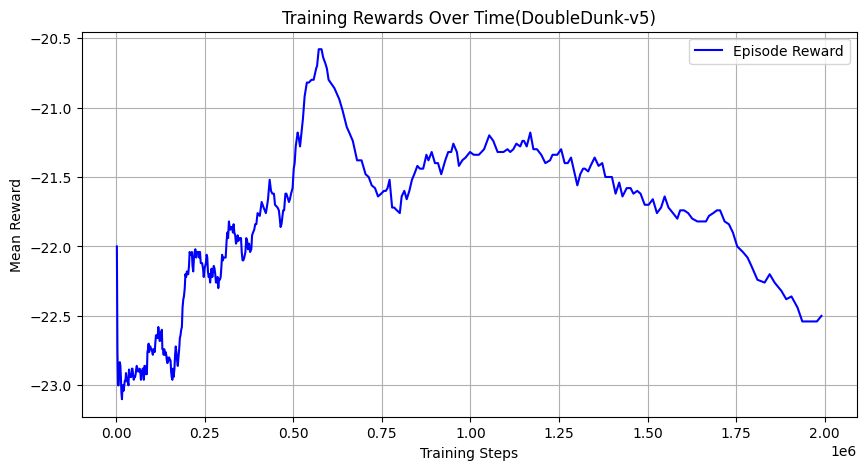

In [7]:
# Plot of episode reward over training steps
plt.figure(figsize=(10, 5))
plt.plot(df["step"], df["reward"], label="Episode Reward", color="blue")
plt.xlabel("Training Steps")
plt.ylabel("Mean Reward")
plt.title("Training Rewards Over Time(DoubleDunk-v5)")
plt.savefig("training_rewards_doubledunk.png")
plt.legend()
plt.grid()
plt.show()

### Loading the Trained Model for Evaluation  
We load the trained model and verify if it was loaded correctly.

### 🎬 Running the Trained Agent  
- The agent interacts with the environment and plays the game.  
- **Gameplay is recorded as a video**.  
- Frame rate is adjusted to slow down gameplay for better visibility.


In [ ]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
import imageio
import numpy as np
import time

# here we load our trained model
model_path = "/kaggle/working/dqn_doubledunk_model.zip"  # saved path
model = DQN.load(model_path)

# Verifying the model loading
print("Model loaded successfully!")
print("Model Policy:", model.policy)

# environment setup
env = make_atari_env("ALE/DoubleDunk-v5", n_envs=1, seed=42)
env = VecFrameStack(env, n_stack=4)  # Frame stacking for better performance

# Printing action space for debugging
print("Action Space:", env.action_space)

# Initialize observation and variables
obs = env.reset()
frames = []  # To store frames for video recording
total_reward = 0  # Track the total reward (score)
episode = 1  # Track the number of episodes

# Frame rate control (im trying to make the gameplay go slower here)
target_fps = 60  # Atari games typically run at 60 FPS
frame_delay = 1.0 / target_fps  # Delay between frames in seconds

# Running the agent in the environment
max_steps = 10000  # Increased the number of steps for longer gameplay
for step in range(max_steps):
    action, _states = model.predict(obs, deterministic=False)  
    obs, rewards, dones, info = env.step(action)  # Take a step in the environment
    total_reward += rewards[0]  # the reward accumulated

    # Determine if you are on offense or defense
    if rewards[0] > 0:
        role = "Offense"
    else:
        role = "Defense"

    # Render the game as an RGB array and save the frame
    frame = env.render(mode="rgb_array")
    frames.append(frame)

    # Introduce a delay to control the frame rate
    time.sleep(frame_delay)

    # Check if the episode has finished
    if dones.any():
        print(f"Episode {episode} finished! Total Reward: {total_reward}")
        obs = env.reset()  # Reset the environment for the next episode
        print(f"Starting Episode {episode + 1}...")
        total_reward = 0  # Reset the total reward
        episode += 1  # Increment the episode counter

# Saving recorded frames as a video
video_path = "/kaggle/working/d_playback.mp4"  
imageio.mimsave(
    video_path,
    frames,
    fps=target_fps,  # Match the target frame rate
    quality=10,  # Maximum quality
    codec="libx264",  # High-quality codec
    pixelformat="yuv420p",  # Standard pixel format for compatibility
)

print(f"✅ Gameplay video saved to {video_path}")

env.close()

### Conclusion  
- A **Deep Q-Network (DQN) agent** was trained on **Atari’s Double Dunk**.  
- The model **learned offensive and defensive strategies** over time.  
- The gameplay was **recorded and analyzed for performance improvements**.  
